# Tutorial: Data cleaning with Notebooks for Apache Spark

The purpose of this tutorial is to illustrate a simple data cleaning workflow with `Notebooks for Apache Spark`.

**USE CASE: data cleaning of 2 CSV dataset with aggregation into a single clean Parquet file.**

## Introduction

**What is Data Cleaning?**

"*Data Cleaning or Data Cleansing is the preparation of raw data by detecting and correcting records within a dataset.*"

In this tutorial, you will be able to leverage the power Apache Spark from within a Jupyter Notebook.

## Requirements

To use `Notebooks for Apache Spark` you need first to create a new notebook from the Control Panel.

You will also need a `Standard Object Storage - S3 API` container for the datasets, preferably in the same region as the notebook.

## Code

The different steps are as follow:

* Setup the environment
* Initialize the Spark Session
* Download and check the `books` dataset
* Prepare the `books` dataset
* Verify the cleaned `books` dataset
* Download and check the `ratings` dataset
* Prepare the `ratings` dataset
* Aggregate the data with SQL
* Check the aggregated data
* Save the data to S3

### Setup the environment

In [1]:
# Import dependencies
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, length, isnan, when

In [2]:
# Define S3 settings
s3_access_key="<access_key>"
s3_secret_key="<secret_key>"
s3_endpoint="s3.<region>.io.cloud.ovh.net"
s3_path="s3a://<bucket>/"

### Initialize the Spark Session

In [3]:
# Init the Spark Session
spark = SparkSession\
    .builder\
    .appName("notebook-spark-data-cleaning")\
    .config("spark.hadoop.fs.s3a.access.key", s3_access_key)\
    .config("spark.hadoop.fs.s3a.secret.key", s3_secret_key)\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")\
    .config("spark.hadoop.fs.s3a.path.style.access", "true")\
    .config("spark.hadoop.fs.s3a.endpoint", s3_endpoint)\
    .config("spark.hadoop.fs.defaultFS", s3_path)\
    .getOrCreate()

In [4]:
# Check PySpark version
print("PySpark version: " + spark.version)

PySpark version: 3.3.2


### Download and check the "books" dataset

In [5]:
# Reading "books" data from the S3 container
df_books = spark.read.options(header="true").csv(s3_path+"books.csv")
display(df_books)

DataFrame[id: string, book_id: string, best_book_id: string, work_id: string, books_count: string, isbn: string, isbn13: string, authors: string, original_publication_year: string, original_title: string, title: string, language_code: string, image_url: string, small_image_url: string]

In [6]:
# Let's take a look at a couple of books
df_books.show(2, truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------
 id                        | 1                                                          
 book_id                   | 2767052                                                    
 best_book_id              | 2767052                                                    
 work_id                   | 2792775                                                    
 books_count               | 272                                                        
 isbn                      | 439023483                                                  
 isbn13                    | 9.78043902348e+12                                          
 authors                   | Suzanne Collins                                            
 original_publication_year | 2008.0                                                     
 original_title            | The Hunger Games                                           
 title               

In [7]:
# Look for null values in the dataset
df_books.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_books.columns]).show()

+---+-------+------------+-------+-----------+----+------+-------+-------------------------+--------------+-----+-------------+---------+---------------+
| id|book_id|best_book_id|work_id|books_count|isbn|isbn13|authors|original_publication_year|original_title|title|language_code|image_url|small_image_url|
+---+-------+------------+-------+-----------+----+------+-------+-------------------------+--------------+-----+-------------+---------+---------------+
|  0|      0|           0|      0|          0| 700|   585|      0|                       21|           590|    0|         1084|        0|              0|
+---+-------+------------+-------+-----------+----+------+-------+-------------------------+--------------+-----+-------------+---------+---------------+



In [9]:
# Check the different values for the books languages
df_books.select("language_code").distinct().collect()

[Row(language_code='""A Man Named Dave"""'),
 Row(language_code='fre'),
 Row(language_code='en'),
 Row(language_code='en-CA'),
 Row(language_code='rus'),
 Row(language_code='ind'),
 Row(language_code='per'),
 Row(language_code=None),
 Row(language_code='nor'),
 Row(language_code='pol'),
 Row(language_code='vie'),
 Row(language_code='ara'),
 Row(language_code='por'),
 Row(language_code='swe'),
 Row(language_code='mul'),
 Row(language_code='eng'),
 Row(language_code='jpn'),
 Row(language_code='nl'),
 Row(language_code='dan'),
 Row(language_code='en-GB'),
 Row(language_code='fil'),
 Row(language_code='tur'),
 Row(language_code='rum'),
 Row(language_code='ita'),
 Row(language_code='Bloody Jack (Bloody Jack, #1)'),
 Row(language_code='en-US'),
 Row(language_code='spa'),
 Row(language_code='ger')]

### Prepare the `books` dataset

Based on the data exploration, we will need to clean the data following these steps:
* **Delete** unncessary or too malformed **columns** by dropping `id`, `best_book_id`, `work_id`, `books_count`, `isbn13`, `title`, `image_url`, and `small_image_url`.
* **Delete** unusable **rows** having null values in `original_title` and `original_publication_year` columns.
* **Filling** empty records replacing null values in the `isbn` column by "0".
* **Normalizing** records of the `language_code` column values to ISO 639-2.

In [10]:
# Clean the "books" dataset
df_books_cleaned = df_books\
    .drop("id", "best_book_id", "work_id", "books_count", "isbn13", "title", "image_url", "small_image_url")\
    .dropna(subset=["original_title", "original_publication_year"])\
    .fillna(value="0", subset=["isbn"])\
    .withColumn('language_code',\
        when(df_books.language_code.isin(["en", "en-CA", "en-GB", "en-US"]), "eng")\
        .when((df_books.language_code.isNull()) | (length(df_books.language_code) != 3), "und")\
        .otherwise(df_books.language_code))
display(df_books_cleaned)

DataFrame[book_id: string, isbn: string, authors: string, original_publication_year: string, original_title: string, language_code: string]

### Verify the clean "books" dataset

In [11]:
# Check there is no more null data
df_books_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_books_cleaned.columns]).show()

+-------+----+-------+-------------------------+--------------+-------------+
|book_id|isbn|authors|original_publication_year|original_title|language_code|
+-------+----+-------+-------------------------+--------------+-------------+
|      0|   0|      0|                        0|             0|            0|
+-------+----+-------+-------------------------+--------------+-------------+



In [12]:
# Check the different values for the books languages
df_books_cleaned.select("language_code").distinct().collect()

[Row(language_code='fre'),
 Row(language_code='und'),
 Row(language_code='rus'),
 Row(language_code='ind'),
 Row(language_code='per'),
 Row(language_code='nor'),
 Row(language_code='pol'),
 Row(language_code='vie'),
 Row(language_code='ara'),
 Row(language_code='por'),
 Row(language_code='swe'),
 Row(language_code='eng'),
 Row(language_code='jpn'),
 Row(language_code='dan'),
 Row(language_code='fil'),
 Row(language_code='tur'),
 Row(language_code='rum'),
 Row(language_code='ita'),
 Row(language_code='spa'),
 Row(language_code='ger')]

### Download and check the "ratings" dataset

In [13]:
# Reading "ratings" data from the S3 container
df_ratings = spark.read.options(header="true").csv(s3_path+"ratings.csv")
display(df_ratings)

DataFrame[book_id: string, user_id: string, rating: string]

In [16]:
# Let's take a look at a couple of ratings
df_ratings.show(10)

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      1|    314|     5|
|      1|    439|     3|
|      1|    588|     5|
|      1|   1169|     4|
|      1|   1185|     4|
|      1|   2077|     4|
|      1|   2487|     4|
|      1|   2900|     5|
|      1|   3662|     4|
|      1|   3922|     5|
+-------+-------+------+
only showing top 10 rows



In [17]:
# Look for null values in the dataset
df_ratings.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_ratings.columns]).show()

+-------+-------+------+
|book_id|user_id|rating|
+-------+-------+------+
|      0|      0|     0|
+-------+-------+------+



### Prepare the `ratings` dataset

Based on the data exploration, we will need to clean the data with a single step:
* **Delete** unncessary **columns** by dropping `user_id`.

In [18]:
# Clean the "ratings" dataset
df_ratings_cleaned = df_ratings.drop("user_id")
display(df_ratings_cleaned)

DataFrame[book_id: string, rating: string]

### Aggregate the data

For the data aggregation, let's try another style of data processing with SQL.

In [19]:
# Create views
df_books_cleaned.createOrReplaceTempView("books")
df_ratings_cleaned.createOrReplaceTempView("ratings")

In [20]:
# Join data
df_books_ratings = spark.sql("""
with books_ratings as (
select cast(b.book_id as integer) as id, original_title as title, authors, cast(original_publication_year as integer) as year, round(avg(rating),2) as rating, language_code, isbn
from books b, ratings r
where b.book_id = r.book_id
group by b.book_id, isbn, authors, original_publication_year, original_title, language_code)

select * from books_ratings order by rating desc
""")
display(df_books_ratings)

DataFrame[id: int, title: string, authors: string, year: int, rating: double, language_code: string, isbn: string]

### Check the aggregated data

In [21]:
# Let's take a look at a couple of records
df_books_ratings.show(10, truncate=False)

+----+--------------------------------------------------------+--------------------------------------+----+------+-------------+----------+
|id  |title                                                   |authors                               |year|rating|language_code|isbn      |
+----+--------------------------------------------------------+--------------------------------------+----+------+-------------+----------+
|9566|Still Life with Woodpecker                              |Tom Robbins                           |1980|4.78  |eng          |184243022X|
|4708|The Beautiful and Damned                                |F. Scott Fitzgerald                   |1922|4.66  |und          |743451503 |
|9569|Villa Incognito                                         |Tom Robbins                           |2003|4.62  |und          |1842431021|
|9531|Peter and the Shadow Thieves                            |Dave Barry, Ridley Pearson, Greg Call |2006|4.56  |eng          |078683787X|
|3885|The Taste of H

### Save the data to S3

In [22]:
# Writing the result to S3 in the parquet format
df_books_ratings.write.mode("overwrite").parquet(s3_path+"books_ratings.pq")

### Check the data is available in the object storage

Let's go back to the `Control Panel` and take look in the object storage:

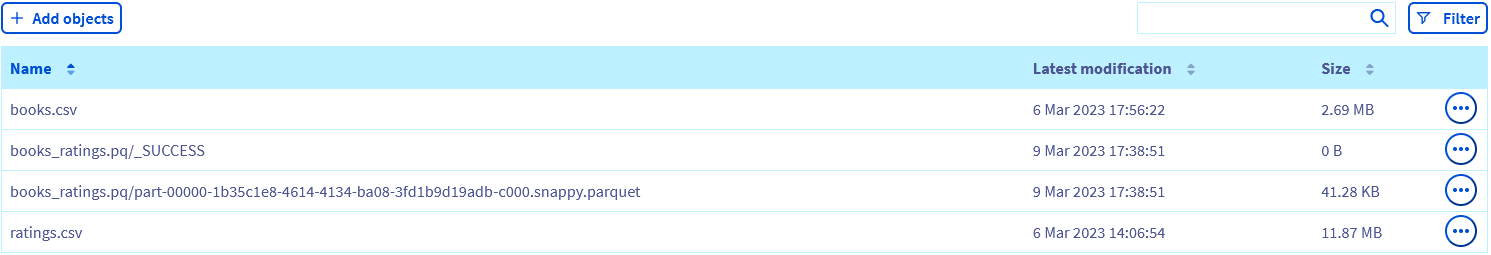

We see that the initial files are still there and that two new elements have been added to the container:
```
books_rating.pq/_SUCCESS
books_rating.pq/part-00000-1b35c1e8-4614-4134-ba08-3fd1b9d19adb-c000.snappy.parquet
```

The `_SUCCESS` file is the marker that the writing job was successful, while the `part-*.pq` file represents the actuel parquet file.
Without going into too much details, these files are tied to the distributed nature of Apache Spark, and Hadoop underneath, and how data are treated in partition.

## Conclusion

Now that your data is saved in your object container, you can stop your `Notebook for Apache Spark`.

Your data is clean, accessible and usable in your BI applications or by your AI teams.